In [124]:
import random
from PIL import Image
import openai
import json
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import matplotlib.patches as patches


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks, save_path=None):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Calculate total area of the image
    total_area = raw_image.size[0] * raw_image.size[1]

    labels_list = []
    label_images_list = []

    for mask in masks:
        # Show the mask with random color
        show_mask(mask, ax=ax, random_color=True)

        # Label the mask
        label_image = label(mask)
        label_images_list.append(label_image)

        # Get properties of the labeled regions
        regions = regionprops(label_image)

        # Classify regions as floor, wall or neither based on their position, size and edge contact
        labels = np.zeros_like(label_image, dtype=np.uint8)
        for region in regions:
            # Check if region is large (more than 10% of total area)
            if region.area > total_area * 0.1:
                # Check if region has more pixels touching the bottom, top, left or right edge
                bottom_edge_touch = np.sum(region.coords[:, 0] == mask.shape[0] - 1)
                top_edge_touch = np.sum(region.coords[:, 0] == 0)
                left_edge_touch = np.sum(region.coords[:, 1] == 0)
                right_edge_touch = np.sum(region.coords[:, 1] == mask.shape[1] - 1)
                # If the region has more pixels touching the bottom edge than the other edges, it's a floor
                if bottom_edge_touch > max(top_edge_touch, left_edge_touch, right_edge_touch):
                    labels[label_image == region.label] = 1  # Floor
                else:
                    labels[label_image == region.label] = 2  # Wall
            else:
                labels[label_image == region.label] = 3  # Neither

        labels_list.append(labels)

        # Add text labels
        for region in regions:
            # Position text at the centroid of the region
            y, x = region.centroid
            if labels[int(y), int(x)] == 1:
                ax.text(x, y, 'Floor', fontsize=12, color='red')
            elif labels[int(y), int(x)] == 2:
                ax.text(x, y, 'Wall', fontsize=12, color='red')
            elif labels[int(y), int(x)] == 3:
                # ax.text(x, y, 'Neither', fontsize=12, color='red')
                continue

    plt.axis("off")
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    del mask
    gc.collect()

    return labels_list, label_images_list

def image_to_ascii(labels, label_image, ascii_width=50, ascii_height=30):
    # Initialize an empty ASCII image
    ascii_image = [['None']*ascii_width for _ in range(ascii_height)]

    # Calculate the step size for sampling the image
    step_size_x = max(label_image.shape[1] // ascii_width, 1)
    step_size_y = max(label_image.shape[0] // ascii_height, 1)



    # Plot the labels array
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(labels, cmap='jet')
    plt.title('Labels before ASCII conversion')
            
    for y in range(0, label_image.shape[0], step_size_y):
        for x in range(0, label_image.shape[1], step_size_x):
            # Calculate the histogram of labels within the chunk
            chunk_labels = labels[y:y+step_size_y, x:x+step_size_x]
            label_counts = np.bincount(chunk_labels.flatten())

            # Find the most common label
            most_common_label = np.argmax(label_counts)

            # Assign the corresponding ASCII character based on the most common label
            ascii_y = min(y // step_size_y, ascii_height - 1)
            ascii_x = min(x // step_size_x, ascii_width - 1)
            if most_common_label == 1:
                ascii_image[ascii_y][ascii_x] = 'Floor'
                color = 'green'  # Green for floor
            elif most_common_label == 2:
                ascii_image[ascii_y][ascii_x] = 'Wall'
                color = 'red'  # Red for wall
            else:
                ascii_image[ascii_y][ascii_x] = 'None'
                color = 'blue'  # Blue for none

            # Draw rectangle for the chunk on the image
            rect = patches.Rectangle((x, y), step_size_x, step_size_y, linewidth=1, edgecolor='r', facecolor=color, alpha=1)
            ax.add_patch(rect)

    plt.show()


    # Convert the ASCII image to a string
    ascii_str = '\n'.join(' '.join(row) for row in ascii_image)

        # Convert the ASCII image to a numerical format for plotting
    ascii_numerical = [[0 if cell == 'None' else 1 if cell == 'Floor' else 2 for cell in row] for row in ascii_image]

    # Create a color map for the plot
    cmap = plt.get_cmap('viridis', 3)  # 3 distinct colors for 'None', 'Floor', and 'Wall'

    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(ascii_numerical, cmap=cmap)

    # Add a color bar
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['None', 'Floor', 'Wall'])

    # Display the plot
    plt.show()

    return ascii_str

def process_image_and_generate_direction(random_image, image_mask, show_masks_on_image):

    random_image = Image.fromarray(random_image)

    # Apply image processing
    aspect_ratio = random_image.size[0] / random_image.size[1]
    new_height = 100
    new_width = int(new_height * aspect_ratio)
    random_image = random_image.resize((new_width, new_height), Image.LANCZOS)

    width, height = random_image.size
    left = width * 0.2
    right = width * 0.8
    top = height * 0.25
    bottom = height * 0.8
    random_image = random_image.crop((left, top, right, bottom))

    new_w = random_image.size[0] 
    new_h = random_image.size[1]

    # Update labels and label_images
    labels, label_images = show_masks_on_image(random_image, image_mask, save_path="crossfar_mask_2.png")

    # Generate ASCII art from the image
    combined_labels = np.maximum.reduce(labels)
    ascii_art = image_to_ascii(combined_labels, label_images[0], new_w//2, new_h//2)
    print(ascii_art)


    # Define the system prompt
    system_prompt = """
    You are a self driving model. It is a robot driving indoors. You take in an ascii description of a scene from a camera pointed forward on a two wheeled robot and output whether to press W, A, or D. the user will give you a 30x30 "image" of word descriptions that define that pixels space. 

    The objective is to not hit objects, you can drive on floor. I want you to respond exactly in two parts. Start with 1.\n
    A description of what you are seeing, what you think is going on. And a plan on how do get through the clear space.

    2.\n
    Return the command W A D W-A or W-D"""

    # Define the function to be called by the AI
    def drive_direction(direction, scene_explanation):
        return f"Driving {direction}. Scene explanation: {scene_explanation}"

    # Generate a response from the AI
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": ascii_art},
        ],
        functions=[
            {
                "name": "drive_direction",
                "description": "A command given to a tank drive two wheeled robot.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "direction": {"type": "string", "enum": ["W", "A", "D"], "description": "The direction to drive in. The image is from a camera on the robot facing forwards. Thus we cannot see behind us."},
                        "scene_explanation": {"type": "string"},
                    },
                    "required": ["direction", "scene_explanation"],
                },
            }
        ],
        function_call={"name": "drive_direction"},
        temperature=0,
    )

    # Extract the response message
    response_message = response["choices"][0]["message"]

    # If the response message contains a function call, execute it
    if response_message.get("function_call"):
        available_functions = {
            "drive_direction": drive_direction,
        }
        function_name = response_message["function_call"]["name"]
        function_to_call = available_functions[function_name]
        function_args = json.loads(response_message["function_call"]["arguments"])
        function_response = function_to_call(
            direction=function_args.get("direction"),
            scene_explanation=function_args.get("scene_explanation"),
        )

        print(function_response)

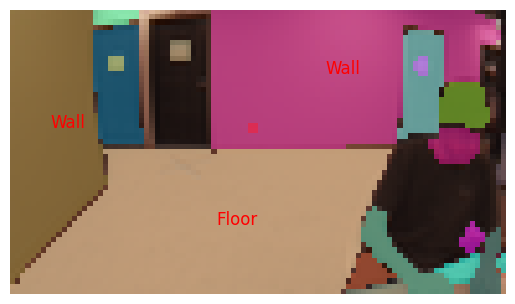

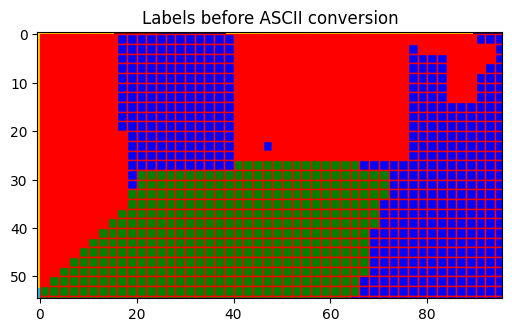

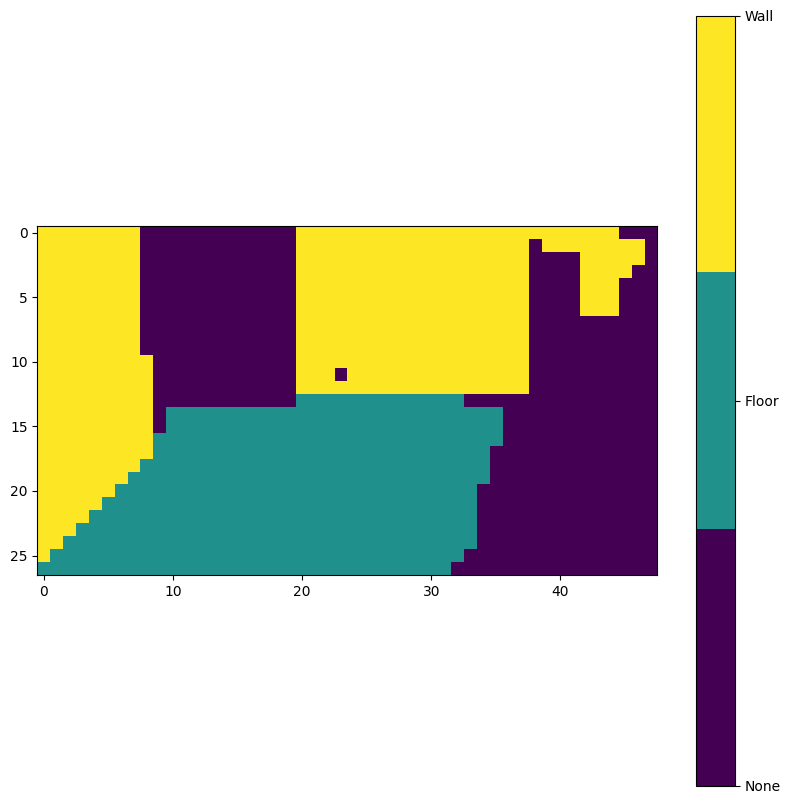

Wall Wall Wall Wall Wall Wall Wall Wall None None None None None None None None None None None None Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall None None None
Wall Wall Wall Wall Wall Wall Wall Wall None None None None None None None None None None None None Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall None Wall Wall Wall Wall Wall Wall Wall Wall None
Wall Wall Wall Wall Wall Wall Wall Wall None None None None None None None None None None None None Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall None None None None Wall Wall Wall Wall Wall None
Wall Wall Wall Wall Wall Wall Wall Wall None None None None None None None None None None None None Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall Wall None None None None Wall Wall Wall Wall None None
Wall Wall Wall Wall Wall Wall Wall Wall 

In [138]:
process_image_and_generate_direction(img_array, img_mask, show_masks_on_image)

In [169]:
import modal
from PIL import Image
import numpy as np

img = Image.open('./testnew.png')
img_array = np.array(img)

f = modal.Function.lookup("chatPID", "ImageProcessor.process_mask")



In [174]:
img_mask = f.remote(img_array)
